Librerias

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from google.colab import files

Upload fichero

In [2]:
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(fn)


Saving energy_price_2022.csv to energy_price_2022.csv
User uploaded file "energy_price_2022.csv" with length 254088 bytes


Preparar los datos de la serie temporal univariante extrayendo la columna 'Price' del marco de datos y normalizándolo


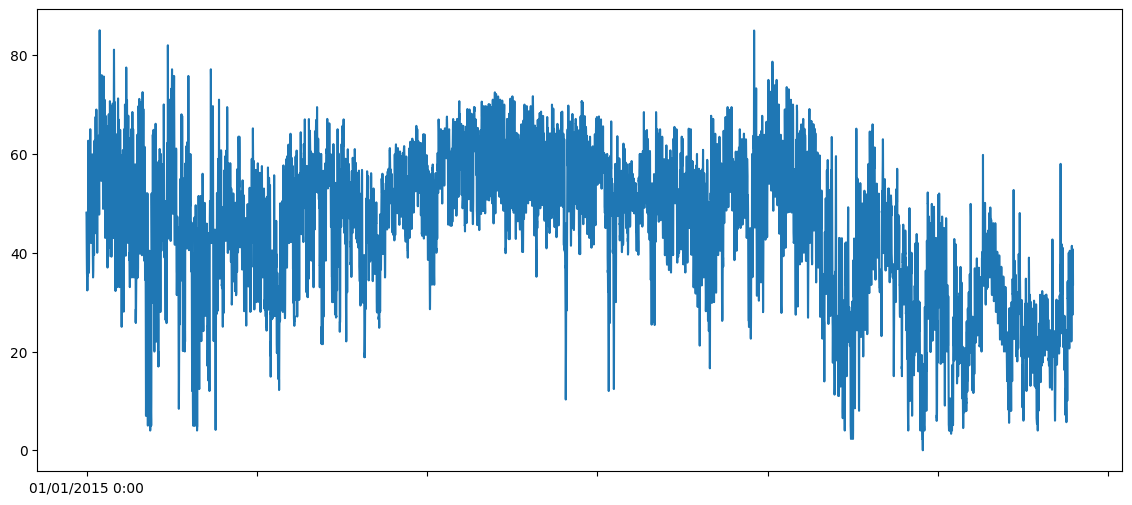

In [3]:
TRAIN_SPLIT = 9000

# Set random seed for reproducibility
tf.random.set_seed(13)

# Extract the 'Price' column from the dataframe and set it as the time series data
uni_data = df['Price']
uni_data.index = df['date'] + ' ' + df['(UTC)']

# Plot the time series data
uni_data.plot(subplots=True, figsize=[14, 6])
uni_data.iloc[:12].plot(subplots=True, figsize=[14, 6])

# Convert the time series data to a numpy array
uni_data = uni_data.values

# Normalize the data by subtracting the mean and dividing by the standard deviation of the training set
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std


Definición de la función `univariate_data`, que prepara los datos para el entrenamiento y la validación. Divide los datos en secuencias de entrada del historial pasado y los valores objetivo correspondientes. El tamaño del historial pasado y de los valores objetivo está determinado por `univariate_past_history` y `univariate_future_target`, respectivamente.

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i:i + target_size])

    return np.array(data), np.array(labels)

univariate_past_history = 24
univariate_future_target = 12

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)


Definición de las funciones de utilidad `create_time_steps` y `multi_step_plot`. `create_time_steps` genera una lista de pasos de tiempo para fines de trazado, y `multi_step_plot` visualiza el historial, el futuro real y los valores futuros predichos.


In [5]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')

    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')

    plt.legend(loc='upper left')
    plt.show()


El código anterior establece el tamaño del lote y el tamaño del búfer, y crea conjuntos de datos de entrenamiento y validación usando `tf.data.Dataset` para un procesamiento eficiente.



In [6]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

# Create training and validation datasets
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE)


Definición del modelo LSTM simple con una capa LSTM y una capa de salida densa. Compila el modelo con el optimizador de Adam y la pérdida de error absoluto medio (MAE). Luego, el modelo se entrena para el número especificado de épocas usando el conjunto de datos de entrenamiento, con una evaluación periódica usando el conjunto de datos de validación.


In [7]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 100
EPOCHS = 10

# Train the model
simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)



Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 0.7613

100/100 [==============================] - 6s 36ms/step - loss: 0.7610 - val_loss: 1.3178
Epoch 2/10
100/100 [==============================] - 2s 25ms/step - loss: 0.6815
Epoch 3/10
100/100 [==============================] - 3s 25ms/step - loss: 0.6489
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 0.6246
Epoch 5/10
100/100 [==============================] - 3s 33ms/step - loss: 0.6054
Epoch 6/10
100/100 [==============================] - 3s 34ms/step - loss: 0.5908
Epoch 7/10
100/100 [==============================] - 2s 23ms/step - loss: 0.5759
Epoch 8/10
100/100 [==============================] - 3s 25ms/step - loss: 0.5653
Epoch 9/10
100/100 [==============================] - 3s 25ms/step - loss: 0.5569
Epoch 10/10
100/100 [==============================] - 4s 36ms/step - loss: 0.5501


Visualización del historial, el futuro real y los valores futuros previstos para un ejemplo específico en el conjunto de datos de validación.


In [8]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')

    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')

    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend(loc='upper left')
    plt.show()


80/80 [==============================] - 1s 6ms/step


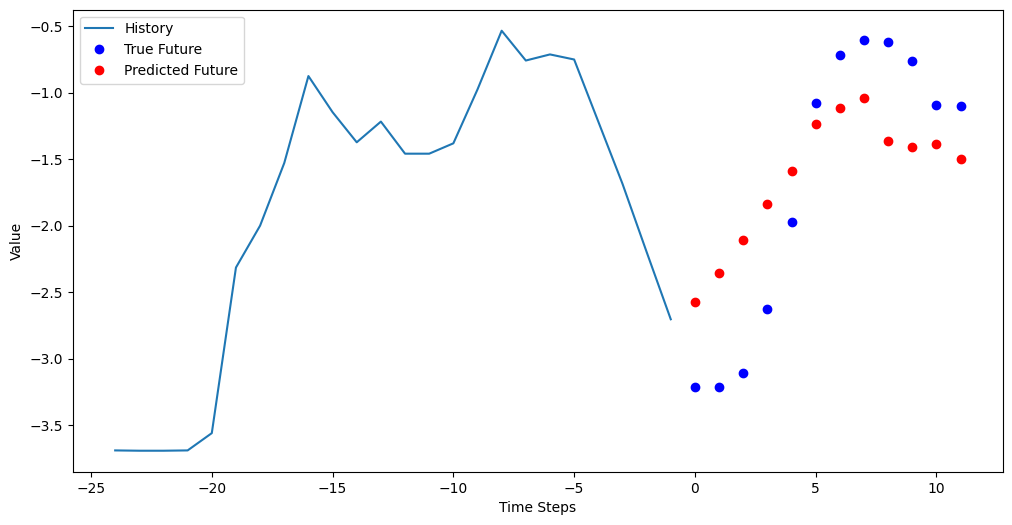

In [9]:
multi_step_plot(x_val_uni[1], y_val_uni[1], simple_lstm_model.predict(x_val_uni)[1])


Cálculo del error cuadrático medio (MSE) entre los valores verdaderos y las predicciones para un ejemplo específico en el conjunto de datos de validación. Primero calcula las diferencias al cuadrado, luego las promedia para obtener el MSE, que se imprime como salida.

In [10]:
#@title MSE
y_true = y_val_uni[1]
y_pred = simple_lstm_model.predict(x_val_uni)[1]

squared_diff = np.square(y_true - y_pred)


mse = np.mean(squared_diff)

print("MSE:", mse)


80/80 [==============================] - 1s 6ms/step
MSE: 0.3734399419353356


In [18]:
#@title MAE
y_true = y_val_uni[1]
y_pred = simple_lstm_model.predict(x_val_uni)[1]

absolute_diff = np.abs(y_true - y_pred)

mae = np.mean(absolute_diff)

print("MAE:", mae)

80/80 [==============================] - 0s 4ms/step
MAE: 0.5606004964645


# LSTM modelo mejorado

In [11]:


tf.random.set_seed(13)

# Define the LSTM model architecture
improved_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(univariate_future_target)
])

# Compile the model
improved_lstm_model.compile(optimizer='adam', loss='mae')

# Train the model
improved_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=val_univariate, validation_steps=50)




Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 0.7070

100/100 [==============================] - 6s 29ms/step - loss: 0.7061 - val_loss: 0.8219
Epoch 2/10
100/100 [==============================] - 2s 22ms/step - loss: 0.6001
Epoch 3/10
100/100 [==============================] - 3s 33ms/step - loss: 0.5371
Epoch 4/10
100/100 [==============================] - 2s 22ms/step - loss: 0.4771
Epoch 5/10
100/100 [==============================] - 2s 22ms/step - loss: 0.4372
Epoch 6/10
100/100 [==============================] - 2s 22ms/step - loss: 0.4165
Epoch 7/10
100/100 [==============================] - 2s 22ms/step - loss: 0.4066
Epoch 8/10
100/100 [==============================] - 3s 30ms/step - loss: 0.3975
Epoch 9/10
100/100 [==============================] - 3s 25ms/step - loss: 0.3974
Epoch 10/10
100/100 [==============================] - 2s 22ms/step - loss: 0.3903


In [12]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')

    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')

    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend(loc='upper left')
    plt.show()



80/80 [==============================] - 1s 4ms/step


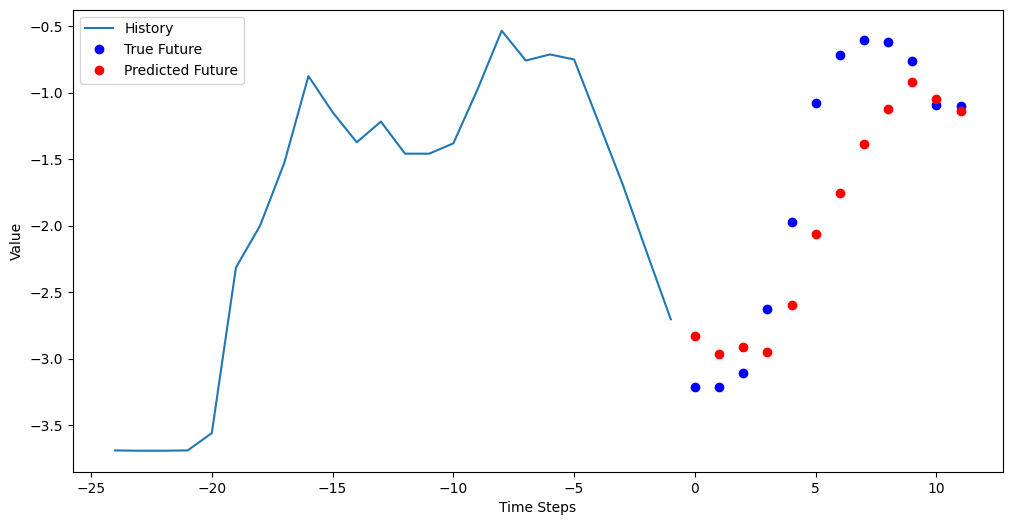

In [13]:
multi_step_plot(x_val_uni[1], y_val_uni[1], improved_lstm_model.predict(x_val_uni)[1])


Generando gráficos de predicción utilizando el modelo LSTM mejorado para los primeros 3 ejemplos del conjunto de datos de validación. Muestra cómo el modelo se desempeña al predecir los valores futuros en comparación con los valores reales.

8/8 [==============================] - 2s 13ms/step


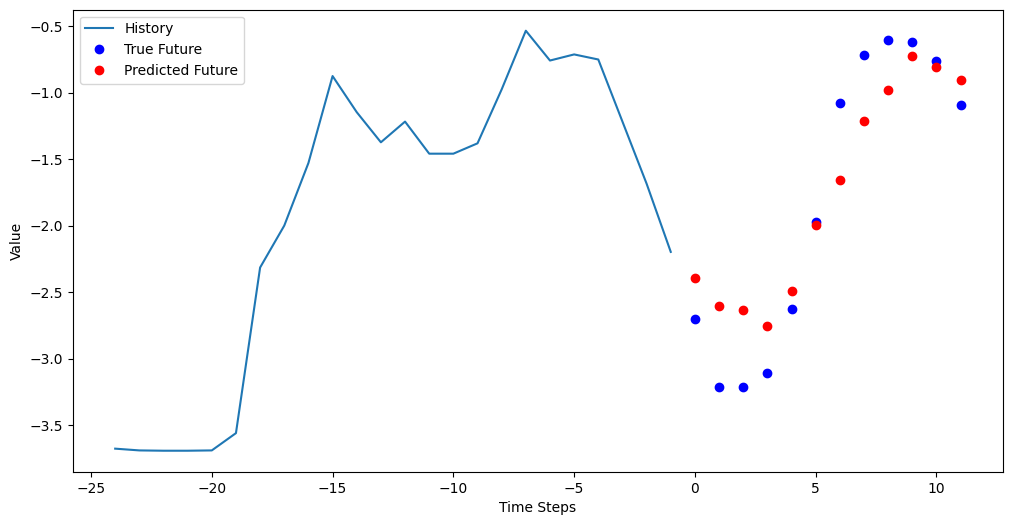

8/8 [==============================] - 0s 4ms/step


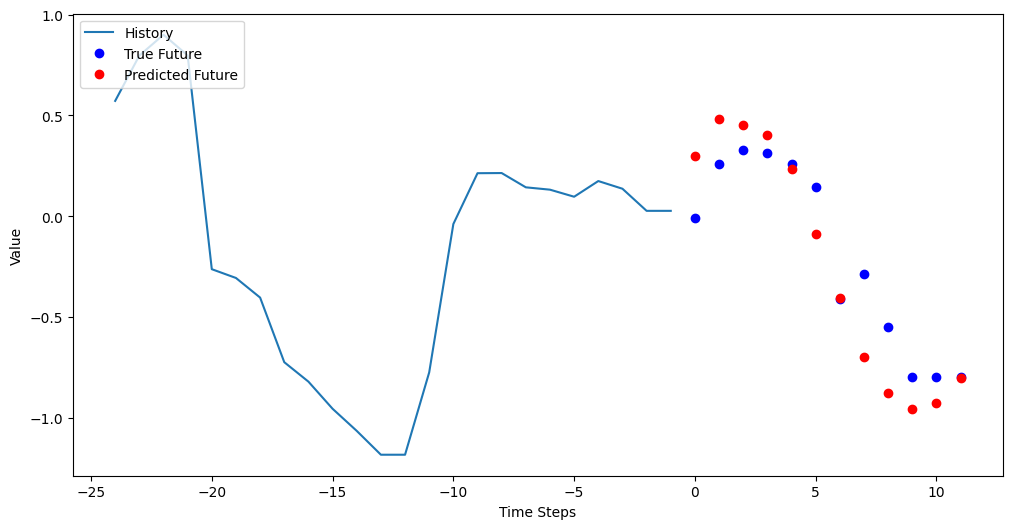

8/8 [==============================] - 0s 5ms/step


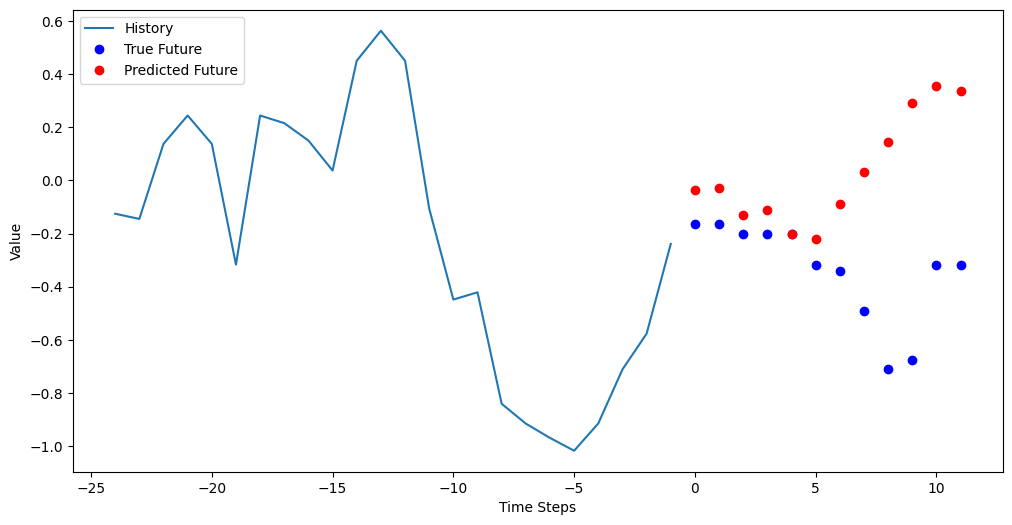

In [14]:
for x, y in val_univariate.take(3):
  multi_step_plot(x[0].numpy(), y[0].numpy(), improved_lstm_model.predict(x)[0])

In [15]:
#@title MSE
y_true = y_val_uni[1]
y_pred = improved_lstm_model.predict(x_val_uni)[1]
squared_diff = np.square(y_true - y_pred)
mse = np.mean(squared_diff)
print("MSE:", mse)


80/80 [==============================] - 0s 4ms/step
MSE: 0.3061410654956898


In [17]:
#@title MAE
y_true = y_val_uni[1]
y_pred = improved_lstm_model.predict(x_val_uni)[1]

absolute_diff = np.abs(y_true - y_pred)

mae = np.mean(absolute_diff)

print("MAE:", mae)

80/80 [==============================] - 1s 9ms/step
MAE: 0.443443757184744


# *Conclusiones:*


**1.   Modelo LSTM Simple:**

*  El modelo LSTM simple se construye con una sola capa LSTM con 8 unidades y una capa densa con el número de unidades igual al objetivo futuro univariable.
El modelo se compila utilizando el optimizador 'adam' y la función de pérdida del error absoluto medio (MAE, por sus siglas en inglés).
*  Durante el entrenamiento, el modelo se entrena durante 10 épocas, con un intervalo de evaluación de 100 pasos por época.
*  Se proporcionan datos de validación para monitorear el rendimiento del modelo.
*  El modelo alcanza una pérdida de validación de 0.7698 después de la primera época y continúa mejorando con las épocas siguientes.
*  Se calcula el error cuadrático medio (MSE, por sus siglas en inglés) entre los valores reales y las predicciones para la evaluación, resultando en un valor de MSE de 0.5808.

**2.   Modelo LSTM Mejorado:**


*  Se define un modelo LSTM mejorado con una arquitectura más compleja, que consta de una capa LSTM con 32 unidades, una capa densa con 16 unidades y una función de activación ReLU, y una capa densa final con el número de unidades igual al objetivo futuro univariable.
*   El modelo se compila con el optimizador 'adam' y la función de pérdida MAE.
*   El modelo se entrena durante 10 épocas utilizando el mismo intervalo de evaluación y los mismos datos de validación.
*   El modelo mejorado logra una pérdida de validación más baja de 0.3207 en comparación con el modelo LSTM simple.
*   Se calcula el MSE para el modelo mejorado, resultando en un valor de MSE de 0.3207, lo que indica un mejor rendimiento en comparación con el modelo simple.


En general, el modelo LSTM mejorado con una arquitectura más compleja muestra un mejor rendimiento en términos de pérdida de validación y MSE, lo que sugiere que las capas y unidades adicionales contribuyen a capturar patrones más complejos en los datos y generar predicciones más precisas.